In [1]:
import cv2                                # state of the art computer vision algorithms library
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt           # 2D plotting library producing publication quality figures
import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API
import torch

print("Environment Ready")

Environment Ready


In [2]:
class EulerAngles:
    roll = 0.0
    pitch = 0.0
    yaw = 0.0
    
    def __init__(self,roll,pitch,yaw):
        self.roll = roll
        self.pitch = pitch 
        self.yaw = yaw 

    def rad2deg(self):
        return np.array([self.pitch*180/np.pi, self.yaw*180/np.pi , (self.roll)*180/np.pi])
        #return np.array([self.pitch*180/np.pi, self.yaw*180/np.pi , (self.roll-np.pi/2)*180/np.pi])

In [3]:
class rotation_estimator:

    total_angles = EulerAngles(0,0,0)
    total_radians = EulerAngles(0,0,0)
    alpha = 0.98 
    firstGyro = True 
    firstAccel = True 
    # keeps the arrival time of previous gyro frame 
    first_ts_gyro = 0 

    def process_gyro(self,gyro_data,ts):
        if self.firstGyro: 
            self.firstGyro = False
            self.first_ts_gyro = ts
            return 

        gyro_angle = np.array([gyro_data.x,gyro_data.y,gyro_data.z])
        dt_gyro = (ts-self.first_ts_gyro)/1000.0
        self.first_ts_gyro = ts 

        gyro_angle = gyro_angle * dt_gyro

        #gyro_data.x : Yaw
        #gyro_data.y : Pitch 
        #gyro_data.z : Roll
        
    
        self.total_radians.yaw   -= gyro_angle[2]
        self.total_radians.roll  += gyro_angle[0]
        self.total_radians.pitch -= gyro_angle[1]


    def process_accel(self,accel_data):

        accel_anglez = np.arctan2(accel_data.y, accel_data.z)
        accel_anglex = np.arctan2(accel_data.x, np.sqrt((accel_data.y * accel_data.y) + (accel_data.z * accel_data.z)))

        if self.firstAccel:
            self.firstAccel = False 
            self.total_radians.yaw = accel_anglex
            self.total_radians.roll = accel_anglez
            self.total_radians.pitch = np.pi 
        else:
            self.total_radians.yaw = (self.total_radians.yaw * self.alpha) + (accel_anglex * (1-self.alpha))
            self.total_radians.roll = (self.total_radians.roll * self.alpha) + (accel_anglez * (1-self.alpha))


    def get_angles(self):
        #return an numpy array of pitch, yaw, roll in degrees 
        angles = np.array([self.total_radians.pitch*180/np.pi , 
                            self.total_radians.yaw*180/np.pi  , 
                            self.total_radians.roll*180/np.pi])
        
        return angles

    def get_radians(self):
        #returns an numpy array of pitch yaw roll in radians 
        angles = np.array([self.total_radians.pitch, 
                            self.total_radians.yaw, 
                            self.total_radians.roll])

        return angles

    def get_rotation_matrix(self):
        # return a np array of rotation matrix 
        rotationM = np.zeros((3,3))

        #a yaws beta roll 
        rotationM[0][0] = (np.cos(self.total_radians.yaw) * np.cos(self.total_radians.pitch))
        rotationM[0][1] = (np.cos(self.total_radians.yaw) * np.sin(self.total_radians.pitch) * np.sin(self.total_radians.roll) 
                            - np.sin(self.total_radians.yaw) * np.cos(self.total_radians.roll) )

        rotationM[0][2] = (np.cos(self.total_radians.yaw) * np.sin(self.total_radians.pitch) * np.cos(self.total_radians.roll) 
                            + np.sin(self.total_radians.yaw) * np.sin(self.total_radians.roll) )

        rotationM[1][0] = (np.sin(self.total_radians.yaw) * np.cos(self.total_radians.pitch))
        rotationM[1][1] = (np.sin(self.total_radians.yaw) * np.sin(self.total_radians.pitch) * np.sin(self.total_radians.roll) 
                            + np.cos(self.total_radians.yaw) * np.cos(self.total_radians.roll) )
        rotationM[1][2] = (np.sin(self.total_radians.yaw) * np.sin(self.total_radians.pitch) * np.cos(self.total_radians.roll) 
                            - np.cos(self.total_radians.yaw) * np.sin(self.total_radians.roll) )

        rotationM[2][0] = -np.sin(self.total_radians.pitch)
        rotationM[2][1] = (np.cos(self.total_radians.pitch) * np.sin(self.total_radians.roll))
        rotationM[2][2] = (np.cos(self.total_radians.pitch) * np.cos(self.total_radians.roll))

        return rotationM
    
    def get_pitch_matrix(self):
        rotationM = np.zeros((3,3))
        # pitch rotation matrix 
        rotationM[0][0] = np.cos(self.total_radians.pitch)
        rotationM[0][2] = np.sin(self.total_radians.pitch)
        rotationM[1][1] = 1
        rotationM[2][0] = -np.sin(self.total_radians.pitch)
        rotationM[2][2] = np.cos(self.total_radians.pitch)
        return rotationM

    def get_roll_matrix(self):
        rotationM = np.zeros((3,3))
        # roll rotation matrix 
        rotationM[0][0] = 1
        rotationM[1][1] = np.cos(self.total_radians.roll)
        rotationM[1][2] = -np.sin(self.total_radians.roll)
        rotationM[2][1] = np.sin(self.total_radians.roll)
        rotationM[2][2] = np.cos(self.total_radians.roll)
        return rotationM

    def get_yaw_matrix(self):
        rotationM = np.zeros((3,3))
        # yaw rotation matrix 
        rotationM[0][0] = np.cos(self.total_radians.yaw)
        rotationM[0][1] = -np.sin(self.total_radians.yaw)
        rotationM[1][0] = np.sin(self.total_radians.yaw)
        rotationM[1][1]= np.cos(self.total_radians.yaw)
        rotationM[2][2] = 1
        return rotationM

In [4]:
# Setup: 
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
cfg.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
cfg.enable_stream(rs.stream.accel, rs.format.motion_xyz32f)
cfg.enable_stream(rs.stream.gyro, rs.format.motion_xyz32f)

profile = pipe.start(cfg)

#set depth sonsor 

depth_sensor = profile.get_device().first_depth_sensor()
preset_range = depth_sensor.get_option_range(rs.option.visual_preset)
print('preset range:'+str(preset_range))

#set camera to preset no Ambient Light to improve the depth qualiy for L515
for i in range(int(preset_range.max)):
    visulpreset = depth_sensor.get_option_value_description(rs.option.visual_preset,i)
    print('%02d: %s'%(i,visulpreset))
    #if visulpreset == "No Ambient Light":# L515 
    if visulpreset == "High Density":# D435    
        depth_sensor.set_option(rs.option.visual_preset, i)

preset range:<pyrealsense2.option_range: 0-5/1 [0]>
00: Custom
01: Default
02: Hand
03: High Accuracy
04: High Density


In [5]:
#estimation -> take data 
estimation = rotation_estimator()

for x in range(5):
  pipe.wait_for_frames()
  
# Store next frameset for later processing:
frameset = pipe.wait_for_frames()

color_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

pose_frame = frameset.get_pose_frame()

gyro = frameset[3].as_motion_frame().get_motion_data()
accel = frameset[2].as_motion_frame().get_motion_data()

ts = frameset.get_timestamp()
print(ts)


pipe.stop()

colorizer = rs.colorizer()

1659985917232.1238


In [111]:
# # Capture the frame
# # Skip 5 first frames to give the Auto-Exposure time to adjust
# for x in range(10):
#   pipe.wait_for_frames()
  
# # Store next frameset for later processing:
# frameset = pipe.wait_for_frames()
# color_frame = frameset.get_color_frame()
# depth_frame = frameset.get_depth_frame()

# # Cleanup:
# pipe.stop()
# print("Frames Captured")

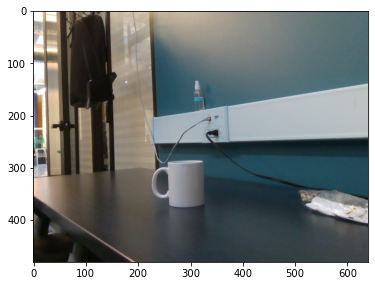

In [6]:
# print the frame 
color = np.asanyarray(color_frame.get_data())
#plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [6, 5]
plt.imshow(color)
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())


In [7]:
#import model 
model = torch.hub.load('ultralytics/yolov5', 'yolov5l6')
model.conf = 0.5

Using cache found in /home/mirsee/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-6-30 Python-3.7.13 torch-1.11.0 CUDA:0 (NVIDIA GeForce RTX 3080 Laptop GPU, 7982MiB)

Fusing layers... 
YOLOv5l6 summary: 476 layers, 76726332 parameters, 0 gradients
Adding AutoShape... 


In [8]:
# Create alignment primitive with color as its target stream:
align = rs.align(rs.stream.color)
frameset = align.process(frameset)

# Update color and depth frames:
aligned_depth_frame = frameset.get_depth_frame()
aligned_depth_img = np.asanyarray(aligned_depth_frame.get_data())
aligned_colorized_depth = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())

In [9]:
def objectDetection(model,image,obj_name):
    # detect the cup with the model yolov5
    results = model(image)
    boxs= results.pandas().xyxy[0].values
    cup_box = np.zeros((4,1))

    img = image.copy()
    for box in boxs:
        print(box[-1])
        if box[-1] == obj_name:
            cup_box[0] = box[0]
            cup_box[1] = box[1]
            cup_box[2] = box[2]
            cup_box[3] = box[3]

    #box0 = box
        cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
        #dist = get_mid_pos(org_img, box, depth_data, 24)
        cv2.putText(img, box[-1],
                    (int(box[0]), int(box[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    print(cup_box)
    print('mid_pos is ')

    mid_pos = [int((cup_box[0] + cup_box[2])//2) , int((cup_box[1] + cup_box[3])//2)]
    mid_pos = np.array(mid_pos)
    print(mid_pos)

    #cv2.circle(img,(600,400),radius = 0, color = (0,255,0),thickness=2)
    cv2.circle(img,mid_pos,radius = 0, color = (255,0,0),thickness=2)
    plt.imshow(img)

    return mid_pos,cup_box,boxs

cup
bottle
[[     226.27]
 [     284.64]
 [     328.09]
 [     376.95]]
mid_pos is 
[277 330]


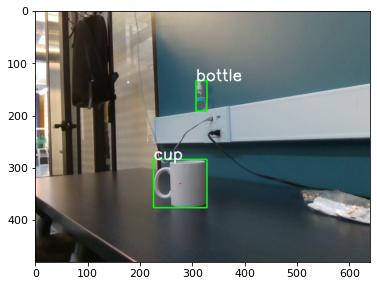

In [10]:
mid_pos,cup_box,boxs = objectDetection(model,color,'cup')

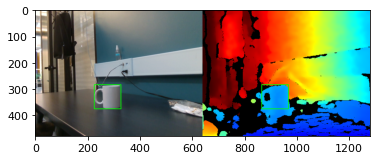

In [11]:
# Show the two frames together:
img = color.copy()
depth_img = aligned_colorized_depth.copy()
cv2.rectangle(img, (int(cup_box[0]), int(cup_box[1])), (int(cup_box[2]), int(cup_box[3])), (0, 255, 0), 2)
cv2.rectangle(depth_img, (int(cup_box[0]), int(cup_box[1])), (int(cup_box[2]), int(cup_box[3])), (0, 255, 0), 2)
images = np.hstack((img, depth_img))
plt.imshow(images)

In [12]:
#get depth
depth_intrin = aligned_depth_frame.profile.as_video_stream_profile().intrinsics

mid_depth = aligned_depth_frame.get_distance(mid_pos[0],mid_pos[1]) 

mid_depth_img = aligned_depth_img[mid_pos[1],mid_pos[0]]


depth_point = rs.rs2_deproject_pixel_to_point(depth_intrin,mid_pos,mid_depth)

print(mid_depth)
print(depth_point)
print("the original depth image is : ")
print(mid_depth_img)
print(mid_depth_img * 0.001)# D435
#print(mid_depth_img * 0.025)# l515

0.6940000057220459
[-0.058096569031476974, 0.09992148727178574, 0.6940000057220459]
the original depth image is : 
694
0.6940000000000001


In [61]:
#test point axis 
for y in range(268,340,5):
    test_depth = aligned_depth_frame.get_distance(396,y)
    test_depth_pt = rs.rs2_deproject_pixel_to_point(depth_intrin,(396,y),test_depth)
    print("point is ",396,y)
    print("depth: " + str(test_depth))
    print(test_depth_pt)
    print("")

point is  396 268
depth: 0.6290000081062317
[0.07098591327667236, 0.026146365329623222, 0.6290000081062317]

point is  396 273
depth: 0.628000020980835
[0.07087305933237076, 0.0312914177775383, 0.628000020980835]

point is  396 278
depth: 0.6270000338554382
[0.07076020538806915, 0.03641995042562485, 0.6270000338554382]

point is  396 283
depth: 0.625
[0.07053449004888535, 0.04146561399102211, 0.625]

point is  396 288
depth: 0.6240000128746033
[0.07042163610458374, 0.04655285179615021, 0.6240000128746033]

point is  396 293
depth: 0.5590000152587891
[0.06308604776859283, 0.0463203489780426, 0.5590000152587891]

point is  396 298
depth: 0.5570000410079956
[0.06286033987998962, 0.050754860043525696, 0.5570000410079956]

point is  396 303
depth: 0.5550000071525574
[0.06263462454080582, 0.05515632778406143, 0.5550000071525574]

point is  396 308
depth: 0.5560000538825989
[0.06274748593568802, 0.05984768643975258, 0.5560000538825989]

point is  396 313
depth: 0.5570000410079956
[0.062860339

---

## Frame Transformation: 
### Depth Frame: 
    the +x is pointing to the charger 
    the +y is point toward the center of earth 
    the +z is point from the camera toward front 

### Original Frame: 
    the +x is pointing toward left side of camera( from back view )
    the +y is pointing from the camera toward the target  
    the +z is pointing downward the center of earth 

### The changing angle is 
    **np.pi for pitch and -np.pi/2 for roll** 
    this is from depth frame to original frame
    pi/2 roll and -pi pitch is from original frame to depth frame 
## Find points in original frame use 

    matrix M * points in depth frame 



In [13]:
#Find the rotation matrix from Gyro + accel 
estimation.process_gyro(gyro,ts)
estimation.process_accel(accel)
angle = estimation.get_angles()

radians = estimation.get_radians()
print("radians is : ")
print(radians)

print(" ")
print("general angle is: pitch yaw roll ")
print(angle)
matrix = estimation.get_rotation_matrix()
roll_matrix = estimation.get_roll_matrix()
pitch_matrix = estimation.get_pitch_matrix()
yaw_matrix = estimation.get_yaw_matrix()

print(" ")
print("total_rotation_matrix is: ")
print(matrix)
print(" ")
print("pitch matrix: ")
print(pitch_matrix)
# test rotation matrix 
def test_rotation_matrix(pitch,yaw,roll):
    # return a np array of rotation matrix 
    rotationM = np.zeros((3,3))

    #a yaws beta roll 
    rotationM[0][0] = (np.cos(yaw) * np.cos(pitch))
    rotationM[0][1] = (np.cos(yaw) * np.sin(pitch) * np.sin(roll)  - np.sin(yaw) * np.cos(roll) )
    rotationM[0][2] = (np.cos(yaw) * np.sin(pitch) * np.cos(roll)  + np.sin(yaw) * np.sin(roll) )

    rotationM[1][0] = (np.sin(yaw) * np.cos(pitch))
    rotationM[1][1] = (np.sin(yaw) * np.sin(pitch) * np.sin(roll)  + np.cos(yaw) * np.cos(roll) )
    rotationM[1][2] = (np.sin(yaw) * np.sin(pitch) * np.cos(roll)  - np.cos(yaw) * np.sin(roll) )

    rotationM[2][0] = -np.sin(pitch)
    rotationM[2][1] = (np.cos(pitch) * np.sin(roll))
    rotationM[2][2] = (np.cos(pitch) * np.cos(roll))

    return rotationM

#roll: pi/2, pitch: -pi inverse the current angle from current frame to original 
# testM = test_rotation_matrix(-np.pi,0,np.pi)
# testpt = np.array([[-1],[-1],[-1]])

# use the current reading foro roll pitch yaw from current to original
testM = test_rotation_matrix(np.pi,0.30857,-1.8368)
testpt = np.array([[1],[1],[1]])

newpt = testM @ testpt 

wrapmid = matrix@depth_point 

print(wrapmid)

print(newpt)
print(newpt[0]*newpt[0] + newpt[1]*newpt[1] + newpt[2] * newpt[2])

radians is : 
[     3.1416   -0.026922     -1.5675]
 
general angle is: pitch yaw roll 
[        180     -1.5425     -89.814]
 
total_rotation_matrix is: 
[[   -0.99964  8.7523e-05    0.026919]
 [   0.026919   0.0032502     0.99963]
 [-1.2246e-16     0.99999  -0.0032513]]
 
pitch matrix: 
[[         -1           0  1.2246e-16]
 [          0           1           0]
 [-1.2246e-16           0          -1]]
[   0.076766     0.69251    0.097665]
[[    -1.1659]
 [     0.3651]
 [     1.2277]]
[          3]


---
## Apply the wrap of the image to correct from the yaw 


height is: 480, and width is 640
[        180     -1.5425     -89.814]


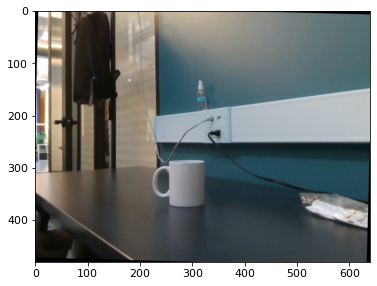

In [14]:
# Apply the pitch warp the image 
image = color.copy()
height,width = image.shape[:2]
center_x,center_y = (width/2,height/2)
print("height is: "+ str(height) + ", and width is " + str(width))
allang = estimation.total_radians.rad2deg()
print(allang)
# wrap the pitch angle to find the level box of the cup ->> find four points, 
# 1st point: center of the cup 
# 2nd point: most away edge (the minimum of y ) in image
# 3rd point: most close edge (the minimum length to the camera ) 
M = cv2.getRotationMatrix2D((center_x,center_y),allang[1],1.0) # rotation from original to flat
inverM = cv2.invertAffineTransform(M)                          # rotation from flat to original 

rotated_img = cv2.warpAffine(image,M,(width,height))

# wraptest = np.array([[368],[403],[1]])

# wrappedpt = M @ wraptest
# inversewrappt = np.array([[357],[405],[1]])


# inversept = inverM @ inversewrappt
# print(inversept)
#cv2.circle(rotated_img,(int(wrappedpt[0]),int(wrappedpt[1])),radius = 0, color = (0,255,0),thickness=2)
plt.imshow(rotated_img)

cup
bottle
[[     223.58]
 [     284.24]
 [     325.87]
 [     376.42]]
mid_pos is 
[274 330]


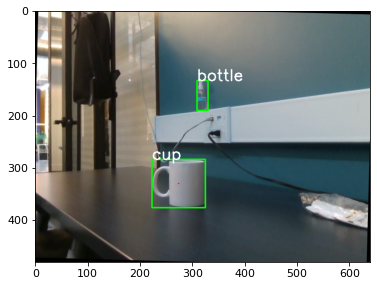

In [16]:
mid_posN,cup_boxN,boxesN = objectDetection(model,rotated_img,'cup')

M = cv2.getRotationMatrix2D((center_x,center_y),allang[1],1.0) # rotation from original to flat
inverM = cv2.invertAffineTransform(M)                          # rotation from flat to original 
#this is cup boundary in flat image 
cup_boundary = np.array([
    [cup_boxN[0],cup_boxN[1]],
    [cup_boxN[0],cup_boxN[3]],
    [cup_boxN[2],cup_boxN[1]],
    [cup_boxN[2],cup_boxN[3]]
])


### Next is trying to find the cropped box around the cup


In [17]:
colorized_depth_copy = aligned_colorized_depth.copy()
depth_copy = aligned_depth_img.copy()

In [18]:
def transferpoints(x,y,mat):
    points = np.array([[x],[y],[1]])
    results = mat @ points
    return results

def find3dCameraFrame(depth_intrin,depth_frame,points):
    #define a function to find the3d point of a point in 3D frame 

    #depth_intrin = depth_frame.profile.as_video_stream_profile().intrinsics
    depth = depth_frame.get_distance(points[0],points[1]) 

    point = rs.rs2_deproject_pixel_to_point(depth_intrin,mid_pos,depth)

    return point

def get_num(points):
    # return the 3D ray away from the camera center 
    return np.sqrt(points[0]*points[0] + points[1]*points[1] + points[2]*points[2])

def get_distance(points1,points2):
    #return the distane between two 3d points in depth frame 
    return np.sqrt((points2[0] - points1[0])**2.0 + (points2[1] - points1[1])**2.0 + (points2[2] - points1[2])**2.0)

    
def findFrontBack (img, cup_box, cup_boxN, depth_boundary):
    tvalue = [mid_depth-0.01,mid_depth+0.15]# assume the furthest point is 10 cm and close is 1cm 
    tvalue = [mid_depth-0.01,mid_depth+0.1]# assume the furthest point is 10 cm and close is 1cm 


the most top point of the cup is: [277 310] and its 3d location is[   0.076764     0.69243    0.074738]
the most bottom point of the cup is: [283 376] and its 3d location is[   0.069895     0.69286      0.1504]
the most right point of the cup is: [327 299] and its 3d location is[   0.020195     0.71993    0.064456]
mid in the y axis is: 0.6358615697354812
mid in the z axis is: 0.11256689683946769
mid in the x axis is: 0.07676410793442949
radius of the cup is : 0.056569600357943534
height of the cup is 0.07565815244892105


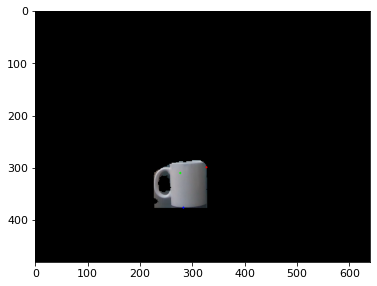

In [20]:
# find the top bottom points 
image = color.copy()
rotated_image = rotated_img.copy()
## change a judgement to make it out of box to zeros 
#tvalue = [mid_depth-0.01,mid_depth+0.1]# assume the furthest point is 10 cm and close is 1cm 
tvalue = [mid_depth-0.015,mid_depth+0.1]# assume the furthest point is 10 cm and close is 1cm 
mid_len = get_num(depth_point)
wrapmid = matrix@depth_point 

right_pt = []
right_3d = wrapmid

left_pt = []
left_3d = wrapmid

top_pt = []
top_3d = wrapmid

bottom_pt = []
bottom_3d = wrapmid

# another variable range minz and maxz, miny and maxy
rangey = [wrapmid[1],wrapmid[1]]
rangez = [wrapmid[2],wrapmid[2]]
rangex = [wrapmid[0],wrapmid[0]]

for x in range(640):
    for y in range(480):
        #if it is inside the depth frame box 
        if cup_box[0]<=x<cup_box[2] and cup_box[1]<=y<cup_box[3]:
            # if it is not black 
            if (image[y][x] != [0,0,0]).any():
            #if (colorized_depth_copy[y][x] != [0,0,0]).any():
                #transfer the point into the flat image and see if it is in the box 
                wrapX,wrapY = transferpoints(x,y,M)
                if cup_boxN[0] <= wrapX <=cup_boxN[2] and cup_boxN[1] <= wrapY <= cup_boxN[3]:
                    # if the wrapped points is in the cup box 
                    depth = aligned_depth_frame.get_distance(x,y) 
                    if depth<tvalue[0] or depth>tvalue[1]:
                        #if in box but it is too far away or too close
                        colorized_depth_copy[y][x] = [0,0,0] 
                        image[y][x] = [0,0,0] 
                    else: 
                        pose = np.array([x,y])                      # position in original image 
                        flatpose = np.array([int(wrapX),int(wrapY)])          # position in wrapped image 
                        points = rs.rs2_deproject_pixel_to_point(depth_intrin,pose,depth) # 3Dpts in depth F
                        length = get_num(points)                    # length of ray to the point in depth F
                        wrapPoint = matrix @ points                 # 3Dpts in original F 
                        # Find the most close point first 
                        # if wrapPoint[2]< right_3d[2] and wrapPoint[0] <= right_3d[0]:
                        #     cv2.circle(rotated_image,np.array(flatpose),radius = 0, color = (255,0,255),thickness=3)
                        #     #if wrapPoint[2] < right_3d[2]:
                        #     print("the most right point of the cup is: "+  str(right_pt) + " and its 3d location is"+ str(right_3d))
                        #     right_3d = wrapPoint
                        #     right_pt = flatpose

                        if abs(wrapPoint[2] - right_3d[2]) <= 0.01:
                            if wrapPoint[0] < right_3d[0] and wrapPoint[1]>right_3d[1]:
                                right_3d = wrapPoint
                                right_pt = pose

                        if abs(wrapPoint[1]-wrapmid[1]) <= 0.005:
                            if wrapPoint[1] <= top_3d[1] and wrapPoint[2] <= top_3d[2]:
                                top_pt = pose 
                                top_3d = wrapPoint
                                #print("the most top point of the cup is: "+ str(top_pt) + " and its 3d location is"+ str(top_3d))

                            if abs(wrapPoint[1] -top_3d[1])<=0.001 and wrapPoint[2] >= bottom_3d[2]:
                            #if wrapPoint[2] >= bottom_3d[2]:
                                bottom_pt = pose
                                bottom_3d = wrapPoint
                                #print("the most bottom point of the cup is: "+  str(bottom_pt) + " and its 3d location is"+ str(bottom_3d))

                else:           
                    image[y][x] = [0,0,0] 
                    #colorized_depth_copy[y][x] = [0,0,0]         
        else:
            image[y][x] = [0,0,0]
            #colorized_depth_copy[y][x] = [0,0,0]   

print("the most top point of the cup is: "+ str(top_pt) + " and its 3d location is"+ str(top_3d))
print("the most bottom point of the cup is: "+  str(bottom_pt) + " and its 3d location is"+ str(bottom_3d))
print("the most right point of the cup is: "+  str(right_pt) + " and its 3d location is"+ str(right_3d))
middle_y = top_3d[1]- abs(top_3d[0]- right_3d[0])
middle_z = top_3d[2] + (bottom_3d[2] - top_3d[2])/2
middle_x = top_3d[0]
print("mid in the y axis is: " + str(middle_y))
print("mid in the z axis is: " + str(middle_z))
print("mid in the x axis is: " + str(middle_x))
print("radius of the cup is : " + str(abs(top_3d[0]- right_3d[0])))
print("height of the cup is "+ str(bottom_3d[2] - top_3d[2]))
# cv2.circle(colorized_depth_copy,np.array(bottom_pt),radius = 0, color = (0,0,255),thickness=3)
# cv2.circle(colorized_depth_copy,np.array(top_pt),radius = 0, color = (0,255,0),thickness=3)
# cv2.circle(colorized_depth_copy,np.array(right_pt),radius=0, color = (255,0,0 ), thickness=3)
# plt.imshow(colorized_depth_copy)
cv2.circle(image,np.array(bottom_pt),radius = 0, color = (0,0,255),thickness=3)
cv2.circle(image,np.array(top_pt),radius = 0, color = (0,255,0),thickness=3)
cv2.circle(image,np.array(right_pt),radius=0, color = (255,0,0 ), thickness=3)
plt.imshow(image)
# cv2.circle(rotated_image,np.array(bottom_pt),radius = 0, color = (0,0,255),thickness=3)
# cv2.circle(rotated_image,np.array(top_pt),radius = 0, color = (0,255,0),thickness=3)
# #cv2.circle(rotated_image,np.array(right_pt),radius = 0, color = (255,0,255),thickness=3)
# cv2.circle(rotated_image,np.array(right_pt),radius = 0, color = (255,0,255),thickness=3)
# plt.imshow(rotated_image)

mid in the y axis is: 0.6638737125828135
mid in the z axis is: 0.11289196702930904
mid in the x axis is: 0.07676410793442949
diameter of the cup is : 0.02855745751061134
height of the cup is 0.07630829282860374
0.691698565253863
0.7297695672222907
0.03807100196842772
 
0.020194507576485953
0.14159623051581835
0.1214017229393324
 
0.6896721847165226
0.7104051950900104
0.020733010373487848
 
0.05066006878437933
0.1514795353317738
the diameter is: 
0.07973636245388006
the height is: 
0.10081946654739447


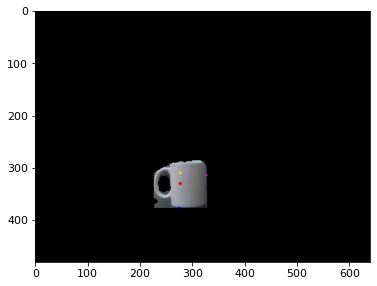

In [21]:
# find the most front and the entire ring with original image
rotated_image = rotated_img.copy()
colorized_depth_copy = aligned_colorized_depth.copy()
image = color.copy()
## change a judgement to make it out of box to zeros 
#tvalue = [mid_depth-0.01,mid_depth+0.1]# assume the furthest point is 10 cm and close is 1cm 
tvalue = [mid_depth-0.01,mid_depth+0.1]# assume the furthest point is 10 cm and close is 1cm 
mid_len = get_num(depth_point)
wrapmid = matrix@depth_point 

far_pt = []
far_3d = wrapmid

close_pt = []
close_3d = wrapmid

top_pt = []
top_3d = wrapmid

bottom_pt = []
bottom_3d = wrapmid
#x,y,z pose 
toplist = [[],[],[],[]]
verlist = [[],[],[],[]]
# find all minimum z to find the rough tsize 
# find the top and bottom and furest 
for x in range(640):
    for y in range(480):
        #if it is inside the depth frame box 
        if cup_box[0]<=x<cup_box[2] and cup_box[1]<=y<cup_box[3]:
            # if it is not black 
            if (image[y][x] != [0,0,0]).any():
                #transfer the point into the flat image and see if it is in the box 
                wrapX,wrapY = transferpoints(x,y,M)
                if cup_boxN[0] <= wrapX <=cup_boxN[2] and cup_boxN[1] <= wrapY <= cup_boxN[3]:
                    # if the wrapped points is in the cup box 
                    depth = aligned_depth_frame.get_distance(x,y) 
                
                    if depth<tvalue[0] or depth>tvalue[1]:
                        #if in box but it is too far away or too close
                        image[y][x] = [0,0,0] 
                    #if tvalue[0] < depth < tvalue[1]:
                    else:
                        #if in box but it is too far away or too close
                        pose = np.array([x,y])                                  # position in original image 
                        flatpose = np.array([int(wrapX),int(wrapY)])            # position in wrapped image 
                        points = rs.rs2_deproject_pixel_to_point(depth_intrin,pose,depth) # 3Dpts in depth F
                        length = get_num(points)                                # length of ray to the point in depth F
                        wrapPoint = matrix @ points                             # 3Dpts in original F 
                        wraplen = get_num(wrapPoint)

                        # Find the most close point first 
                        if wrapPoint[1] <close_3d[1] and wrapY <= (cup_boxN[1]+30) and wrapPoint[2] < close_3d[2]:
                            close_pt = pose 
                            close_3d = wrapPoint

                        #if wrapPoint[2] <= far_3d[2] and wrapPoint[1] >= far_3d[1]:
                        if abs(wrapPoint[2]-close_3d[2]) <= 0.01 and wrapY <= (cup_boxN[1]+30) and wrapPoint[1] > far_3d[1]:
                            far_3d = wrapPoint
                            far_pt = pose

                        if abs(wrapPoint[1] - wrapmid[1]) <= 0.005 and abs(wrapX - mid_posN[0]) <= 20 and wrapPoint[2] > bottom_3d[2]:
                            # print("original point is "+ str(bottom_3d) + "pose is "+ str(bottom_pt))
                            # print("new point is " + str(wrapPoint)+ "pose is " + str(pose))
                            bottom_pt = pose
                            bottom_3d = wrapPoint
                            
                        # use the limitation with cup_boxN, if the size is not too far away from cup boundary y -> store points find z 
                        if wrapY <= (cup_boxN[1]+30): 
                            toplist[0].append(wrapPoint[0])
                            toplist[1].append(wrapPoint[1])
                            toplist[2].append(wrapPoint[2])
                            toplist[3].append(pose)
                        
                        if abs(wrapX-mid_posN[0]) <= 5 :
                            verlist[0].append(wrapPoint[0])
                            verlist[1].append(wrapPoint[1])
                            verlist[2].append(wrapPoint[2])
                            verlist[3].append(pose)
                    # else: 
                    #     image[y][x] = [0,0,0]
                else:           
                    image[y][x] = [0,0,0]        
        else:
            image[y][x] = [0,0,0] 

# print("the most top point of the cup is: "+ str(top_pt) + " and its 3d location is"+ str(top_3d))
# print("the most bottom point of the cup is: "+  str(bottom_pt) + " and its 3d location is"+ str(bottom_3d))
# print("the most far point of the cup is: "+  str(far_pt) + " and its 3d location is"+ str(far_3d))
# print("")
middle_y = close_3d[1]- abs(close_3d[1]- far_3d[1])
middle_z = close_3d[2] + (bottom_3d[2] - close_3d[2])/2
middle_x = close_3d[0]
print("mid in the y axis is: " + str(middle_y))
print("mid in the z axis is: " + str(middle_z))
print("mid in the x axis is: " + str(middle_x))
# cv2.circle(colorized_depth_copy,np.array(bottom_pt),radius = 0, color = (0,0,255),thickness=3)
# #cv2.circle(colorized_depth_copy,np.array(top_pt),radius = 0, color = (0,255,0),thickness=3)
# cv2.circle(colorized_depth_copy,np.array(right_pt),radius=0, color = (255,0,0 ), thickness=3)
# cv2.circle(colorized_depth_copy,np.array(close_pt),radius=0, color = (255,255,0 ), thickness=3)
# plt.imshow(colorized_depth_copy)
cv2.circle(image,np.array(bottom_pt),radius = 0, color = (0,0,255),thickness=3)
cv2.circle(image,np.array(close_pt),radius=0, color = (255,255,0 ), thickness=3)
cv2.circle(image,np.array(far_pt),radius = 0, color = (255,0,255),thickness=3)
cv2.circle(image,mid_pos,radius = 0, color = (255,0,0),thickness=5)
plt.imshow(image)
print("diameter of the cup is : " + str(abs(close_3d[1]  - far_3d[1])))
print("height of the cup is " + str(bottom_3d[2] - close_3d[2]))
print(min(toplist[1]))
print(max(toplist[1]))
diameter = (max(toplist[1]) - min(toplist[1]) + max(toplist[0]) - min(toplist[0]) )/2
print(max(toplist[1]) - min(toplist[1])) #use close y and far y in flat frame
print(" ")
print(min(toplist[0]))
print(max(toplist[0]))
print(max(toplist[0]) - min(toplist[0]))
print(" ")
print(min(verlist[1]))
print(max(verlist[1]))
print(max(verlist[1]) - min(verlist[1]))
print(" ")
print(min(verlist[2]))
print(max(verlist[2]))
print("the diameter is: ")
print(diameter)
print("the height is: ")
print(max(verlist[2]) - min(verlist[2]))


[   0.044519     0.52426     0.24683]
[286 434]
[305 332]
[   0.035603     0.52049     0.18568]
original position is [-0.015973621979355812, 0.17272356152534485, 0.5470000505447388]
new position is [   0.022352     0.51883     0.24415]
the top point is [   0.026527     0.52136     0.15002]oroginal point is [  -0.038072     0.17462       0.553]


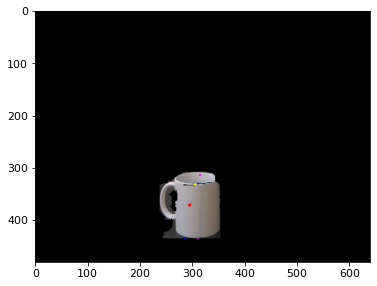

In [79]:
print(bottom_3d)
print(bottom_pt)
print(close_pt)
print(wrapmid)

depth = aligned_depth_frame.get_distance(310,434) 
pose = np.array([310,434])                      # position in original image 

points = rs.rs2_deproject_pixel_to_point(depth_intrin,pose,depth) 

newpoints = matrix@points
print("original position is " + str(points))
print("new position is " + str(newpoints))

print("the top point is "+str(close_3d) + "oroginal point is " + str(matrix.T @ bottom_3d))


cv2.circle(image,np.array(pose),radius = 0, color = (255,0,255),thickness=3)
plt.imshow(image)

mid in the y axis is: 0.41950447781715294
mid in the z axis is: 0.15822503454462616
mid in the x axis is: -0.10385381305239268
diameter of the cup is : 0.09290041023096096
height of the cup is 0.09795174700602384
0.5109820148893872
0.6053052982790749
the diameter is: 
0.09432328338968765
 
the height is: 
0.11047495642926279


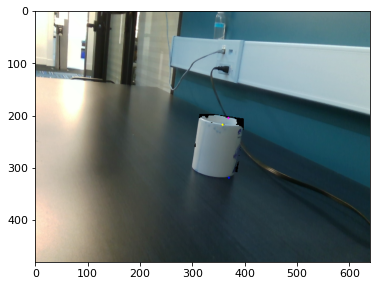

In [107]:
# test with minz,minx,miny,maxy, maxz,minz
rotated_image = rotated_img.copy()
colorized_depth_copy = aligned_colorized_depth.copy()
image = color.copy()
## change a judgement to make it out of box to zeros 
tvalue = [mid_depth-0.01,mid_depth+0.1]# assume the furthest point is 10 cm and close is 1cm 
mid_len = get_num(depth_point)
wrapmid = matrix@depth_point 

far_pt = []
far_3d = wrapmid

close_pt = []
close_3d = wrapmid

top_pt = []
top_3d = wrapmid

bottom_pt = []
bottom_3d = wrapmid
# miny maxy, minz, maxz
minypt = []
miny = np.inf 
maxypt = []
maxy = 0 

minzpt = []
minz = np.inf 
maxzpt = []
maxz = 0 

#x,y,z pose 
toplist = [[],[],[],[]]
verlist = [[],[],[],[]]

# find the top and bottom and furest 
for x in range(640):
    for y in range(480):
        #if it is inside the depth frame box 
        if cup_box[0]<=x<cup_box[2] and cup_box[1]<=y<cup_box[3]:
            # if it is not black 
            if (image[y][x] != [0,0,0]).any():
                #transfer the point into the flat image and see if it is in the box 
                wrapX,wrapY = transferpoints(x,y,M)
                if cup_boxN[0] <= wrapX <=cup_boxN[2] and cup_boxN[1] <= wrapY <= cup_boxN[3]:
                    # if the wrapped points is in the cup box 
                    depth = aligned_depth_frame.get_distance(x,y) 
                
                    if depth<tvalue[0] or depth>tvalue[1]:
                        #if in box but it is too far away or too close
                        image[y][x] = [0,0,0] 
                    #if tvalue[0] < depth < tvalue[1]:
                    else:
                        #if in box but it is too far away or too close
                        pose = np.array([x,y])                      # position in original image 
                        flatpose = np.array([int(wrapX),int(wrapY)])          # position in wrapped image 
                        points = rs.rs2_deproject_pixel_to_point(depth_intrin,pose,depth) # 3Dpts in depth F
                        length = get_num(points)                    # length of ray to the point in depth F
                        wrapPoint = matrix @ points                 # 3Dpts in original F 
                        wraplen = get_num(wrapPoint)
                        
                        # Find the most close point first 
                        if wrapPoint[1] <close_3d[1] and wrapY <= (cup_boxN[1]+30) and wrapPoint[2] < close_3d[2]:
                            close_pt = pose 
                            close_3d = wrapPoint

                        #if wrapPoint[2] <= far_3d[2] and wrapPoint[1] >= far_3d[1]:
                        if abs(wrapPoint[2]-close_3d[2]) <= 0.01 and wrapY <= (cup_boxN[1]+30) and wrapPoint[1] > far_3d[1]:
                            far_3d = wrapPoint
                            far_pt = pose
                            
                        # use the limitation with cup_boxN, if the size is not too far away from cup boundary y -> store points find z 
                        if wrapY <= (cup_boxN[1]+30): 
                            toplist[0].append(wrapPoint[0])
                            toplist[1].append(wrapPoint[1])
                            toplist[2].append(wrapPoint[2])
                            toplist[3].append(pose)
                        
                        if abs(wrapX-mid_posN[0]) <= 2 :
                            verlist[0].append(wrapPoint[0])
                            verlist[1].append(wrapPoint[1])
                            verlist[2].append(wrapPoint[2])
                            verlist[3].append(pose)

                        if abs(wrapPoint[1] - wrapmid[1]) <= 0.005 and abs(wrapPoint[0] - wrapmid[0]) <= 0.05 and wrapPoint[2] > bottom_3d[2]:
                            # print("original point is "+ str(bottom_3d) + "pose is "+ str(bottom_pt))
                            # print("new point is " + str(wrapPoint)+ "pose is " + str(pose))
                            bottom_pt = pose
                            bottom_3d = wrapPoint

                        if wrapPoint[2] > maxz:
                            maxz = wrapPoint[2]
                            maxzpt = pose
                        elif wrapPoint[2]< minz:
                            minz = wrapPoint[2]
                            minzpt = pose
                        if wrapPoint[1] > maxy:
                            maxy = wrapPoint[1]
                            maxypt = pose
                        elif wrapPoint[1]< miny:
                            miny = wrapPoint[1]
                            minypt = pose
                    # else: 
                    #     image[y][x] = [0,0,0]
        #         else:           
        #             image[y][x] = [0,0,0]        
        # else:
        #     image[y][x] = [0,0,0] 

# print("the most top point of the cup is: "+ str(top_pt) + " and its 3d location is"+ str(top_3d))
# print("the most bottom point of the cup is: "+  str(bottom_pt) + " and its 3d location is"+ str(bottom_3d))
# print("the most far point of the cup is: "+  str(far_pt) + " and its 3d location is"+ str(far_3d))
# print("")
middle_y = close_3d[1]- abs(close_3d[1]- far_3d[1])
middle_z = close_3d[2] + (bottom_3d[2] - close_3d[2])/2
middle_x = close_3d[0]
print("mid in the y axis is: " + str(middle_y))
print("mid in the z axis is: " + str(middle_z))
print("mid in the x axis is: " + str(middle_x))
# cv2.circle(colorized_depth_copy,np.array(bottom_pt),radius = 0, color = (0,0,255),thickness=3)
# #cv2.circle(colorized_depth_copy,np.array(top_pt),radius = 0, color = (0,255,0),thickness=3)
# cv2.circle(colorized_depth_copy,np.array(right_pt),radius=0, color = (255,0,0 ), thickness=3)
# cv2.circle(colorized_depth_copy,np.array(close_pt),radius=0, color = (255,255,0 ), thickness=3)
# plt.imshow(colorized_depth_copy)
cv2.circle(image,np.array(bottom_pt),radius = 0, color = (0,0,255),thickness=3)
cv2.circle(image,np.array(close_pt),radius=0, color = (255,255,0 ), thickness=3)
cv2.circle(image,np.array(far_pt),radius = 0, color = (255,0,255),thickness=3)
# cv2.circle(image,np.array(minzpt),radius=0, color = (255,255,0 ), thickness=3)
# cv2.circle(image,np.array(maxzpt),radius = 0, color = (255,0,255),thickness=3)
# cv2.circle(image,np.array(minypt),radius=0, color = (255,255,0 ), thickness=3)
# cv2.circle(image,np.array(maxypt),radius = 0, color = (0,255,0),thickness=3)
plt.imshow(image)


print("diameter of the cup is : " + str(abs(close_3d[1] - far_3d[1])))
print("height of the cup is " + str(bottom_3d[2] - close_3d[2]))
print(min(toplist[1]))
print(max(toplist[1]))
print("the diameter is: ")

print(maxy - miny) #use close y and far y in flat frame
print(" ")

print("the height is: ")
print(maxz - minz )

In [41]:
def getArea(a,b,c,d):
    return abs(c-a) * abs(d-b)

cup_box1 = np.zeros((4,1))
cup_boxes1 = np.array([[0,0,0,0]])
maxArea = 0 
for box in boxs:
    print(box[-1])
    cup_box1 = np.zeros((5,1))
    if box[-1] == "cup":
        area = getArea(box[0],box[1],box[2],box[3])
        if area > maxArea: 
            cup_box1[0] = box[0]
            cup_box1[1] = box[1]
            cup_box1[2] = box[2]
            cup_box1[3] = box[3]
        #cup_box[4] = int() * int()
            cup_boxes1 = np.insert(cup_boxes1,0,cup_box, axis = 0)

if len(cup_boxes1) == 1:
    print("did not found the required objects")
else:
    print("found object at : ")
    mid_pos = [int((cup_box[0] + cup_box[2])//2) , int((cup_box[1] + cup_box[3])//2)]
    mid_pos = np.array(mid_pos)
    print(mid_pos)


cup
bottle
found object at : 
[277 330]
